In [1]:
import os
import torch
import json
import numpy as np
from dataset import MRIDataset
from model.maisi_vae import VAE_Lite
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch.nn as nn
import argparse

# If all classes/functions (Model, get_betas, etc.) are in train.py, import them:
# (Adjust if you placed Model or get_betas in different modules.)
from train import Model, get_betas

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
Importing from timm.models.layers is deprecated, please import via timm.layers


In [2]:
def load_models(run_folder, device):
    """Load the trained VAE and Discriminator models."""
    # Load hyperparameters
    with open(os.path.join(run_folder, 'hparams.json'), 'r') as f:
        hparams = json.load(f)
    hparams['device'] = device
    
    # Initialize models
    #vae = VAE(use_reparam=True).to(device)
    vae = VAE_Lite(
    spatial_dims=3,           # 3D model
    in_channels=1,            # e.g., single-channel input
    out_channels=1,           # single-channel reconstruction
    channels=(32, 64, 128),   # downsampling channels
    num_res_blocks=(1, 1, 1),    # one ResBlock per level
    attention_levels=(False, False, False),
    latent_channels=4,
    norm_num_groups=16,
    norm_eps=1e-5,
    with_encoder_nonlocal_attn=False,
    with_decoder_nonlocal_attn=False,
    include_fc=False,
    use_combined_linear=False,
    use_flash_attention=False,
    use_convtranspose=False,
    num_splits=8,
    dim_split=0,
    norm_float16=False,
    print_info=False,
    save_mem=True,
    ).to(hparams['device'])
    #disc = Discriminator().to(device)
    
    # Load checkpoint
    checkpoint = torch.load(os.path.join(run_folder, 'best_vae_gan.pth'), 
                          map_location=device)
    
    vae.load_state_dict(checkpoint['vae_state_dict'])
    #disc.load_state_dict(checkpoint['disc_state_dict'])
    
    return vae, hparams

In [3]:
def load_diffusion(ckpt_path, opt, device):
    betas = get_betas('linear', 0.0001, 0.02, 1000)
    diffusion_model = Model(opt, betas, opt.loss_type, opt.model_mean_type, opt.model_var_type)
    # diffusion_model = nn.DataParallel(diffusion_model)
    diffusion_model.to(device)
    
    checkpoint = torch.load(ckpt_path, map_location=device)
    state_dict = checkpoint["model_state"]
    
    new_state_dict = {}
    for k, v in state_dict.items():
        # Remove "module." so that it matches a non-DataParallel model
        if k.startswith("module."):
            new_key = k.replace("module.", "")
        else:
            new_key = k
        new_state_dict[new_key] = v

    diffusion_model.load_state_dict(new_state_dict, strict=False)

    diffusion_model.eval()
    
    print(f"Epoch loaded: {checkpoint["epoch"]}")
    
    return diffusion_model

In [4]:
def get_args():

    parser = argparse.ArgumentParser()
    parser.add_argument('--model_dir', type=str, default='./checkpoints_1', help='path to save trained model weights')
    parser.add_argument('--experiment_name', type=str, default='dit3d', help='experiment name (used for checkpointing and logging)')

    # Data params
    parser.add_argument('--dataroot', default='/space/mcdonald-syn01/1/projects/jsawant/DSC250/diffusion/latent_data')
    parser.add_argument('--category', default='chair')
    parser.add_argument('--num_classes', type=int, default=2)

    parser.add_argument('--bs', type=int, default=1, help='input batch size')
    parser.add_argument('--workers', type=int, default=2, help='workers')
    parser.add_argument('--niter', type=int, default=1000, help='number of epochs to train for')

    parser.add_argument('--nc', default=3)
    parser.add_argument('--npoints', default=2048)
    
    '''model'''
    parser.add_argument("--model_type", type=str, choices=["DiT-S/4","DiT-B/4"], default="DiT-S/4")
    parser.add_argument('--beta_start', default=0.0001)
    parser.add_argument('--beta_end', default=0.02)
    parser.add_argument('--schedule_type', default='linear')
    parser.add_argument('--time_num', type=int, default=1000)

    #params
    parser.add_argument('--window_size', type=int, default=0)
    parser.add_argument('--window_block_indexes', type=tuple, default='')
    parser.add_argument('--attention', default=True)
    parser.add_argument('--dropout', default=0.1)
    parser.add_argument('--embed_dim', type=int, default=64)
    parser.add_argument('--loss_type', default='mse')
    parser.add_argument('--model_mean_type', default='eps')
    parser.add_argument('--model_var_type', default='fixedsmall')

    parser.add_argument('--lr', type=float, default=2e-4, help='learning rate for E, default=0.0002')
    parser.add_argument('--beta1', type=float, default=0.5, help='beta1 for adam. default=0.5')
    parser.add_argument('--decay', type=float, default=0, help='weight decay for EBM')
    parser.add_argument('--grad_clip', type=float, default=None, help='weight decay for EBM')
    parser.add_argument('--lr_gamma', type=float, default=0.998, help='lr decay for EBM')

    parser.add_argument('--model', default='', help="path to model (to continue training)")


    '''distributed'''
    parser.add_argument('--world_size', default=1, type=int,
                        help='Number of distributed nodes.')
    parser.add_argument('--node', type=str, default='localhost')
    parser.add_argument('--port', type=int, default=12345)
    parser.add_argument('--dist_url', type=str, default='tcp://localhost:12345')
    parser.add_argument('--dist_backend', default='nccl', type=str,
                        help='distributed backend')
    parser.add_argument('--distribution_type', default='single', choices=['multi', 'single', None],
                        help='Use multi-processing distributed training to launch '
                             'N processes per node, which has N GPUs. This is the '
                             'fastest way to use PyTorch for either single node or '
                             'multi node data parallel training')
    parser.add_argument('--rank', default=0, type=int,
                        help='node rank for distributed training')
    parser.add_argument('--gpu', default=0, type=int,
                        help='GPU id to use. None means using all available GPUs.')

    '''eval'''
    parser.add_argument('--saveIter', default=10, type=int, help='unit: epoch')
    parser.add_argument('--diagIter', default=50000, type=int, help='unit: epoch')
    parser.add_argument('--vizIter', default=50000, type=int, help='unit: epoch')
    parser.add_argument('--print_freq', default=10, type=int, help='unit: iter')

    parser.add_argument('--manualSeed', default=42, type=int, help='random seed')

    parser.add_argument('--debug', action='store_true', default=False, help = 'debug mode')
    parser.add_argument('--use_tb', action='store_true', default=False, help = 'use tensorboard')
    parser.add_argument('--use_pretrained', action='store_true', default=False, help = 'use pretrained 2d DiT weights')
    parser.add_argument('--use_ema', action='store_true', default=True, help = 'use ema')
    
    parser.add_argument('--sampleIter', type=int, default=10, help='Generate sample latents every X epochs')

    opt = parser.parse_args([])

    return opt

In [5]:
vae_run_folder = "/space/mcdonald-syn01/1/projects/jsawant/DSC250/VAE_GAN/best_vae_gan"
diffusion_model_path = "/space/mcdonald-syn01/1/projects/jsawant/DSC250/diffusion_HC/checkpoints_2/dit3d/epoch_9999.pth"
device = 'cuda:1'
opt = get_args()

In [6]:
vae, hparams = load_models(vae_run_folder, device)
vae.eval()
diffusion_model = load_diffusion(diffusion_model_path, opt, device)

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


Epoch loaded: 9999


You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


In [7]:
custom_label = torch.tensor([0], device=device)  # shape (batch_size,)
samples, evolve = diffusion_model.diffusion.p_sample_loop(
    denoise_fn=diffusion_model._denoise,
    shape=(1, 4, 28, 34, 28),
    device=device,
    label=custom_label
)

In [13]:
from PIL import Image

In [45]:
evolve_decoded = []
gif_path = "/space/mcdonald-syn01/1/projects/jsawant/DSC250/gif_axial"
with torch.no_grad():
    for i in range(len(evolve)):
        out = vae.decode(torch.Tensor(evolve[i]).to(device))
        out = out.detach().cpu().numpy()
        out = (out - out.min())/ (out.max() - out.min())
        out = out*255
        slice = Image.fromarray(out[0][0][:,:,60])
        slice = slice.convert("L")
        slice.save(os.path.join(gif_path,f"{i}.png"))
        
        #evolve_decoded.append(out.detach().cpu().numpy())

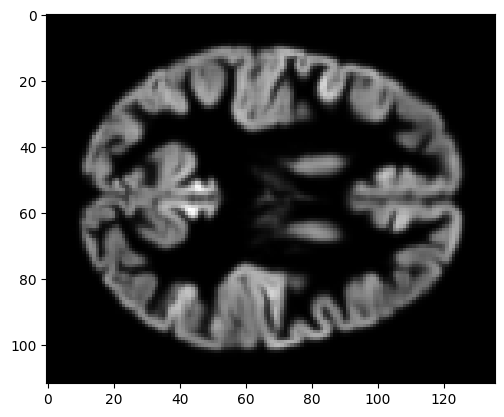

In [43]:
# z = torch.randn(1,4,28,34,28).to(device)
with torch.no_grad():
    out = vae.decode(samples)
out = out.cpu().numpy()
plt.imshow(out[0][0][:,:,60], cmap='gray')

<PIL.Image.Image image mode=F size=112x112 at 0x7F2A9BD22DE0>


In [11]:
print(samples.size())
sample = samples.cpu().numpy()
sample = sample[0]
print(sample.shape)


torch.Size([1, 4, 28, 34, 28])
(4, 28, 34, 28)


In [10]:
import pickle
import glob
latent_pkls = glob.glob("/space/mcdonald-syn01/1/projects/jsawant/DSC250/diffusion_HC/latent_data_gan/train/*.pkl")

In [31]:
min_diff = float('inf')
diff_list = []
mean_logvar = []
for i in tqdm(range(len(latent_pkls))):
    latent_file = latent_pkls[i]
    with open(latent_file,"rb") as f:
        latent = pickle.load(f)
    if latent['label']==0:
        diff = np.sum(np.abs(latent['mu'] - sample))/(28*34*28*4)
        mean_logvar.append(np.mean(latent['logvar']))
        diff_list.append(diff)
        if min_diff > diff:
            min_diff = diff

100%|██████████| 2695/2695 [00:01<00:00, 2001.59it/s]


In [33]:
diff_list

[0.7768147297981692,
 0.7772215331445078,
 0.7785319938522284,
 0.7812168812837635,
 0.774676008098552,
 0.7853383296678046,
 0.7769849394836059,
 0.7740542261826605,
 0.7797678641769208,
 0.77905874263768,
 0.7768458701840111,
 0.7805676225568352,
 0.7814779476243623,
 0.7749334841358418,
 0.7743766940369898,
 0.7773372288368472,
 0.7723357897846639,
 0.7737504425598364,
 0.77433668780012,
 0.7770124162946429,
 0.7754665342699579,
 0.7762309025172569,
 0.7760801097782863,
 0.7805535544295843,
 0.7891579727594162,
 0.7779658250018757,
 0.7795772850155688,
 0.7793138007155987,
 0.7783971010279112,
 0.7772852793461135,
 0.7751208393513656,
 0.7758197028811524,
 0.7733209250497074,
 0.7725005041078932,
 0.7696915680334634,
 0.7751550571400435,
 0.7810830875318877,
 0.7767934077928046,
 0.7760283068305447,
 0.7734763338929321,
 0.7722836204794418,
 0.7778304925485819,
 0.7750085874193428,
 0.775966758773822,
 0.7809884940304247,
 0.77380971920018,
 0.7790903959239946,
 0.7785281837344312,


In [32]:
np.mean(mean_logvar)

-0.60414076

In [10]:
#import numpy as np
import nibabel as nib

# Assume 'data' is your 112x136x112 NumPy array


# Create an affine transformation matrix. Here we use the identity matrix.
affine = np.eye(4)

# Create a NIfTI image from the data
img = nib.Nifti1Image(out[0][0], affine)

# Save the NIfTI image to file (output filename can be .nii or .nii.gz)
nib.save(img, 'test.nii')

In [ ]:
for i in range(len(evolve)):
    plt.figure()
    plt.imshow(evolve_decoded[i][0][0][:,:,50], cmap='gray')

In [1]:
import glob

In [9]:
train = set(glob.glob("/space/mcdonald-syn01/1/projects/jsawant/DSC250/diffusion_HC/latent_data_gan/train/*.pkl"))
val = set(glob.glob("/space/mcdonald-syn01/1/projects/jsawant/DSC250/diffusion_HC/latent_data_gan/val/*.pkl"))

In [10]:
train.intersection(val)

set()